# Prosper Loans Data Exploration

## Table of Contents
<a id='contents'></a>
<ul>
<li><a href="#wrangle">Preliminary Wrangling</a></li>
<li><a href="#univariate">Univariate Exploration</a></li>
<li><a href="#'bivariate'">Bivariate Exploration</a></li>
<li><a href="#multivariate">Multivariate Exploration</a></li>
<li><a href="#links">Links Used</a></li>    
</ul>

## Preliminary Wrangling
<a id='wrangle'></a>

>_This document contains the data on borrowers of Prosper. It came into .csv file of 86.5 MB. Due to a large size of the file it was impossible to open it in Google Sheets so the analysis was perormed via Jupyter Notebook only. The description of the data attributes can be found  [here](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0)._

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [26]:
loans = pd.read_csv('prosperLoanData.csv')
print(loans.shape)

(113937, 81)


In [27]:
# to display the list containing so many columns I will need to create a loop
dtypes = {}
for idx,val in zip(list(loans.dtypes.index),list(loans.dtypes.values)):
    dtypes[idx]=val
dtypes

{'ListingKey': dtype('O'),
 'ListingNumber': dtype('int64'),
 'ListingCreationDate': dtype('O'),
 'CreditGrade': dtype('O'),
 'Term': dtype('int64'),
 'LoanStatus': dtype('O'),
 'ClosedDate': dtype('O'),
 'BorrowerAPR': dtype('float64'),
 'BorrowerRate': dtype('float64'),
 'LenderYield': dtype('float64'),
 'EstimatedEffectiveYield': dtype('float64'),
 'EstimatedLoss': dtype('float64'),
 'EstimatedReturn': dtype('float64'),
 'ProsperRating (numeric)': dtype('float64'),
 'ProsperRating (Alpha)': dtype('O'),
 'ProsperScore': dtype('float64'),
 'ListingCategory (numeric)': dtype('int64'),
 'BorrowerState': dtype('O'),
 'Occupation': dtype('O'),
 'EmploymentStatus': dtype('O'),
 'EmploymentStatusDuration': dtype('float64'),
 'IsBorrowerHomeowner': dtype('bool'),
 'CurrentlyInGroup': dtype('bool'),
 'GroupKey': dtype('O'),
 'DateCreditPulled': dtype('O'),
 'CreditScoreRangeLower': dtype('float64'),
 'CreditScoreRangeUpper': dtype('float64'),
 'FirstRecordedCreditLine': dtype('O'),
 'CurrentC

>**Since the dataset contains a lot of variables I won't be using all of them and select only those that I deem important in the analysis:**
- ListingKey
- ListingCreationDate
- Term
- LoanStatus
- BorrowerAPR
- ProsperScore
- ListingCategory
- BorrowerState
- Occupation
- EmploymentStatus
- IsBorrowerHomeowner
- CreditScoreRangeLower
- TotalCreditLinespast7years
- TotalInquiries
- CurrentDelinquencies
- StatedMonthlyIncome
- LoanOriginalAmount

In [28]:
# creating a subset of data with selected attributes
loans = loans[['ListingKey', 'ListingCreationDate', 'Term', 'LoanStatus',
       'BorrowerAPR', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 
       'EmploymentStatus', 'IsBorrowerHomeowner', 'CreditScoreRangeLower','TotalCreditLinespast7years',
       'TotalInquiries', 'CurrentDelinquencies','StatedMonthlyIncome', 
       'LoanOriginalAmount']]

### Handling NaNs.

In [29]:
%%capture
# replace na with 0 to indicate that there's no data for the ProsperScore
loans.ProsperScore.fillna(0,inplace=True)
# drop na since I can't restore the missing data and it's relatively small part of all dataset
loans.dropna(inplace=True)

### Renaming columns.

In [30]:
%%capture
loans.rename(columns = {'ListingKey':'Key','ListingCreationDate':'Date','LoanStatus':'Status',
                        'ListingCategory (numeric)':'Category',
                        'BorrowerAPR':'APR','BorrowerState':'State', 'IsBorrowerHomeowner':'Homeowner',
                        'CreditScoreRangeLower': 'CreditScore', 'TotalCreditLinespast7years':'CreditLines',
                        'StatedMonthlyIncome':'Income', 'LoanOriginalAmount':'Amount',
                        'TotalInquiries':'Inquiries','CurrentDelinquencies':'Delinquencies'},inplace = True)

In [31]:
loans.columns

Index(['Key', 'Date', 'Term', 'Status', 'APR', 'ProsperScore', 'Category',
       'State', 'Occupation', 'EmploymentStatus', 'Homeowner', 'CreditScore',
       'CreditLines', 'Inquiries', 'Delinquencies', 'Income', 'Amount'],
      dtype='object')

### Replacing values.

In [32]:
replace_stat = {'Past Due (1-15 days)': 'Past Due 1-120 days', 'Past Due (16-30 days)': 'Past Due 1-120 days', 
                'Past Due (31-60 days)': 'Past Due 1-120 days', 'Past Due (61-90 days)': 'Past Due 1-120 days',
               'Past Due (91-120 days)':'Past Due 1-120 days'}
loans.Status = loans.Status.replace(replace_stat)

In [33]:
loans.drop(loans.query('Status in ["FinalPaymentInProgress","Past Due (>120 days)","Cancelled"]').index,inplace=True)

In [34]:
replace_cat = {0: 'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 
               4: 'Personal Loan', 5: 'Student Use', 6: 'Auto', 7: 'Other', 8:'Baby&Adoption', 
               9: 'Boat', 10: 'Cosmetic Procedure', 11: 'Engagement Ring', 12: 'Green Loans', 
               13: 'Household Expenses', 14: 'Large Purchases', 15: 'Medical/Dental', 16: 'Motorcycle',
               17: 'RV', 18: 'Taxes', 19: 'Vacation', 20: 'Wedding Loans'}
loans.Category = loans.Category.replace(replace_cat)

In [35]:
loans.Homeowner = loans.Homeowner.replace({True:'Homeowner',False:'Not a homeowner'})

### Changing column data types.

In [36]:
for i in ['CreditScore','CreditLines','Inquiries','Delinquencies','ProsperScore']:
    loans[i] = loans[i].astype(int)

In [37]:
# convert cut, color, and clarity into ordered categorical types
# NOTE: the ProsperScore values should be ranked 1-10 but 11 score is also present. I decided not to delete them.
ordinal_var_dict = {'Status': ['Completed','Current','Past Due 1-120 days','Defaulted','Chargedoff'],
                    'ProsperScore': list(np.arange(0,12,1))}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loans[var] = loans[var].astype(ordered_var)
    
for var in ['Category','State','Occupation','EmploymentStatus','Term','Homeowner']:
    convert = pd.api.types.CategoricalDtype(ordered = False)
    loans[var] = loans[var].astype(convert)

In [38]:
loans.Date = pd.to_datetime(loans.Date)

In [39]:
loans.columns

Index(['Key', 'Date', 'Term', 'Status', 'APR', 'ProsperScore', 'Category',
       'State', 'Occupation', 'EmploymentStatus', 'Homeowner', 'CreditScore',
       'CreditLines', 'Inquiries', 'Delinquencies', 'Income', 'Amount'],
      dtype='object')

### Correcting the values.

In [40]:
loans.drop(loans.query('Status in ("Past Due (>120 days)","Cancelled","FinalPaymentInProgress")').index,inplace = True)

In [41]:
#Full-time and Part-time are considered employed too.
loans.EmploymentStatus = loans.EmploymentStatus.replace({'Full-time':'Employed','Part-time':'Employed'})

### Describing the final data set.

In [42]:
# descriptive statistics for numeric variables
loans.describe()

APR    CreditScore    CreditLines      Inquiries  \
count  105939.000000  105939.000000  105939.000000  105939.000000   
mean        0.220403     689.698034      26.939758       5.355365   
std         0.080998      60.355026      13.606757       6.072158   
min         0.006530       0.000000       2.000000       0.000000   
25%         0.157130     660.000000      17.000000       2.000000   
50%         0.211160     680.000000      25.000000       4.000000   
75%         0.286750     720.000000      35.000000       7.000000   
max         0.423950     880.000000     136.000000     379.000000   

       Delinquencies        Income         Amount  
count  105939.000000  1.059390e+05  105939.000000  
mean        0.510737  5.682114e+03    8530.912317  
std         1.768275  7.664096e+03    6283.911223  
min         0.000000  0.000000e+00    1000.000000  
25%         0.000000  3.330458e+03    4000.000000  
50%         0.000000  4.750000e+03    7000.000000  
75%         0.000000  6.916667e+03   12000.000000  
max        83.000000  1.750003e+06   35000.000000

In [43]:
loans.shape

(105939, 17)

In [44]:
loans.dtypes

Key                         object
Date                datetime64[ns]
Term                      category
Status                    category
APR                        float64
ProsperScore              category
Category                  category
State                     category
Occupation                category
EmploymentStatus            object
Homeowner                 category
CreditScore                  int64
CreditLines                  int64
Inquiries                    int64
Delinquencies                int64
Income                     float64
Amount                       int64
dtype: object

### What is the structure of the dataset?

_After the cleaning there are 106,159 loan records in the dataset with 17 features. 7 variables are numeric in nature, 1 variable is an object (containing unique keys),7 categorical nominal and 2 are categorical ordered type._

### What is/are the main feature(s) of interest in your dataset?

_I'm interested to see what kind of people loan money in Prosper and what variables affect the loan amount and the APR the most._

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

_I expect to see that credit score affects both loan amount and APR since it's the main characteristic determining the financial discipline a prospective borrower. I also expect to see thata loan amount and APR are impacted by income, number of delinqencies and credit lines. I also want to find out if a loan amount, the fact of owning a home, term, state or employment status can impact the likelyhood of paying out a loan._

## Univariate Exploration
<a id='univariate'></a>

_First, I'll explore the loan amount via histogram with a regular scale._ 

In [45]:
binsize = 1000
bins = np.arange(1000, loans.Amount.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'Amount', bins = bins)
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of applications');

In [46]:
loans.Amount.max()

35000

_It looks like there are some outliers, so I'll use log scale now._

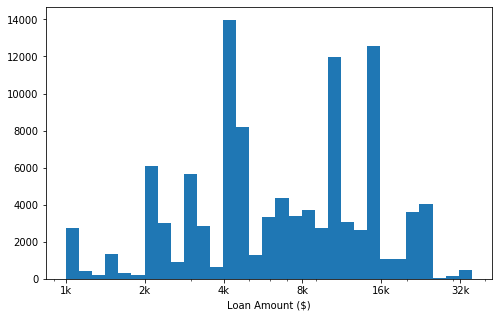

In [47]:
log_binsize = 0.05
bins = 10 ** np.arange(3, np.log10(loans.Amount.max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'Amount', bins = bins)
plt.xscale('log')
ticks1,ticks2  = [1e3,2e3,4e3,8e3,16e3,32e3],['1k', '2k', '4k', '8k', '16k','32k']
plt.xlabel('Loan Amount ($)')
plt.xticks(ticks1, ticks2);

In [48]:
loans.Amount.value_counts().iloc[:10]

4000     13574
15000    12093
10000    10596
5000      6344
2000      5701
3000      5048
25000     3478
20000     3188
7500      2844
7000      2797
Name: Amount, dtype: int64

_The loan amount variable has multimodal distribution which indicates that some standards were applied in determining the loan amount. After looking closer at the data with the log scale applied and limiting the subset of the data it was discovered that the loan amount variable has a lot of values with even numbers like 10000, 15000, etc. This might happen because Prosper are probably offering some loan packages on good terms and borrowers are accepting these offers._

In [49]:
loans.Income.describe()

count    1.059390e+05
mean     5.682114e+03
std      7.664096e+03
min      0.000000e+00
25%      3.330458e+03
50%      4.750000e+03
75%      6.916667e+03
max      1.750003e+06
Name: Income, dtype: float64

_As it can be seen from using .describe() mehtod the minimum income is 0 and the maximum is 1,750,000. This will give us an extremely right-skewed distribution so I will use a log scale._

In [50]:
log_binsize = 0.05
bins = 10 ** np.arange(3, np.log10(loans.Income.max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'Income', bins = bins)
plt.xscale('log')
ticks1,ticks2 = [1e3,5e3,1e4,5e4,1e5,5e5,1e6],['1k', '5k', '10k', '50k', '100k','500k','1m']
plt.xticks(ticks1, ticks2)
plt.xlabel('Monthly income ($)');

In [51]:
np.percentile(loans.Income, 75)

6916.666667

_As it can be seen from the income distribution the median monthly income is somewhere around 5000. The shape of the distribution is close to the normal and the 75 percent of the data are below 6900 threshold which points out to the fact that most clients of Prospers belong the middle class given that the borrowers provided the correct income value._

In [52]:
base_color = sb.color_palette()[0]

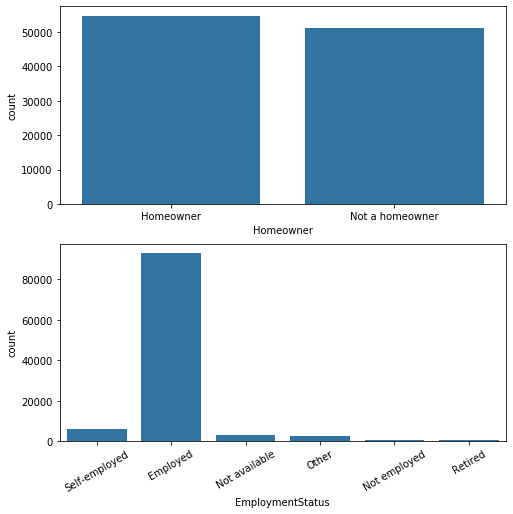

In [53]:
fig, ax = plt.subplots(2,1, figsize = (8,8))

for x,y in enumerate(['Homeowner','EmploymentStatus']):
    sb.countplot(data = loans, x = y, color = base_color,ax = ax[x])
    plt.xticks(rotation = 30);

_As it can be seen from the barcharts the vast majority of borrowers are employed and work full-time. It's interesting to see that the proportion of home owners is close to the proportion of those who doesn't own a home. Also it's worth noting that almost all the borrowers are employed._

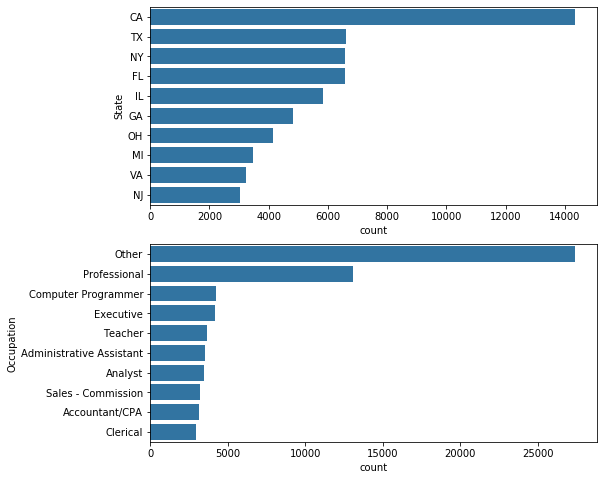

In [54]:
fig, ax = plt.subplots(2,1, figsize = [8,8])

for x,y in enumerate(['State','Occupation']):
    order = loans[y].value_counts().iloc[:10].index
    pl = sb.countplot(data = loans, y = y, color = base_color,order=order,ax = ax[x]);

_The distribution of states almost repeats the distribution of [most populated states](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population) so I will calculate the application-to-population ratio._

In [168]:
orderx = loans['State'].value_counts().iloc[:10]
states_pop = pd.DataFrame({'state':orderx.index,'count':orderx})

states_pop['population'] = [39512223,28995881,19453561,21477737,12671821,10617423,11689100,9986857,8535519,8882190]
states_pop['pop_ratio'] = states_pop['count']/states_pop['population']
states_sorted=states_pop.sort_values(by='pop_ratio',ascending=False)
states_sorted

state  count  population  pop_ratio
IL    IL   5827    12671821   0.000460
GA    GA   4833    10617423   0.000455
VA    VA   3226     8535519   0.000378
CA    CA  14351    39512223   0.000363
OH    OH   4131    11689100   0.000353
MI    MI   3468     9986857   0.000347
NJ    NJ   3047     8882190   0.000343
NY    NY   6574    19453561   0.000338
FL    FL   6564    21477737   0.000306
TX    TX   6599    28995881   0.000228

In [169]:
states_sorted['pop_ratio'].plot(kind='bar', title='States',color=base_color);

_As it can be seen from the charts the occupation don't give us a lot of helpful information since the most common occupation is 'Other' which indicates that borrowers are not willing to disclose it. It's interesting though that among top-10 occupation we can see that at least 5 of them - Computer Programmer, Administrative Assistant, Analyst, Accountant/CPA, Clerical are office jobs. It's also interesting that Prosper loans are popular among teachers. The state distribution also shows that Illinois and Georgia has the highest ratio of applications-to-population and the Texax has the lowest ratio._

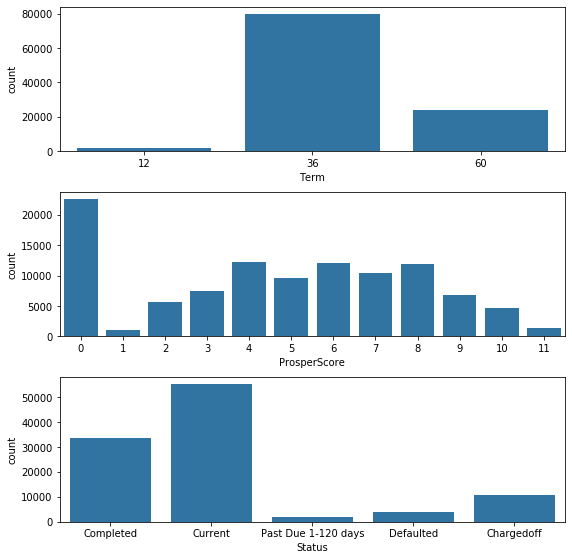

In [170]:
fig, ax = plt.subplots(3,1, figsize = [8,8])
fig.tight_layout(pad=2.0)

for x,y in enumerate(['Term','ProsperScore','Status']):
    sb.countplot(data = loans, x = y, color = base_color,ax = ax[x]);

_It can be seen that 36-month term and 12-month term is the least common. Also, there is a large gap in the Prosper Score (lacking data is indicated as "0") but from the available data it can be seen that the distribution is symmetrical and that most borrowers have the score between 4 and 8. The most of loans are still current and completed._

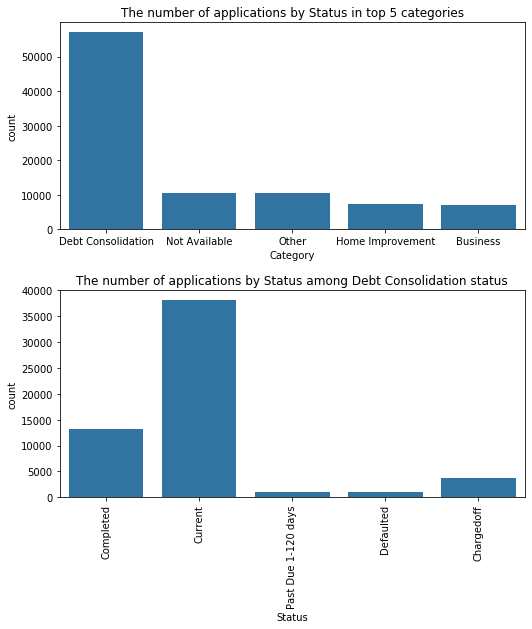

In [171]:
fig, ax = plt.subplots(2, 1, figsize = (8,8))
fig.tight_layout(pad=4.0)
# percentage of statuses in each group

order = loans['Category'].value_counts().iloc[:5].index
debt_cons = loans[loans.Category == 'Debt Consolidation']

sb.countplot(data = loans, x = 'Category', color = base_color, order = order,
                   ax=ax[0]).set_title('The number of applications by Status in top 5 categories');


sb.countplot(data = debt_cons, x = 'Status', color = base_color,
                    ax=ax[1]).set_title('The number of applications by Status among Debt Consolidation status')
plt.xticks(rotation = 90);

_That's really interesting that the most common reason for taking a loan is a debt consolidation which gives me the idea Prospers loans are easy to obtain or have a better conditions that other loaners offer._

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

_The most common income value of a borrower is around $5k monthly, the most borrowers are employed, the proportion of homeowners almost the same of those who doesn't own a home. Office-related occupations of borrowers are the most popular ones and the highest or ratios of applications-to-population of borrowers were observed in Illinois and Georgia states. The majority of loans are in completed or current status, the most common reason for appying for a loan is a debt consoliation. I had to perform log transformation for income scale since the income had outliers._

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

_The distribution by state turned out to be different when I calculated applications-to-population ratio. It was also surprising to find out that the most popular reason for getting a loan is to consolidate other debts and that the number of charged off and defaulted loans is larger than the number of delayed loans._

## Bivariate Exploration
<a id='bivariate'></a>

_First, let's look at pairwise distributions of the data_

In [172]:
numeric_vars = ['APR', 'CreditScore', 'CreditLines', 'Inquiries', 'Delinquencies','Income','Amount']
nominal_vars = ['Term', 'Homeowner', 'EmploymentStatus']
ordinal_vars = ['ProsperScore','Status']

_Since the monthly income is extremely right-skewed I will remove the numbers beyond 90th percentile._

In [173]:
np.percentile(loans.Income,90)

9965.599999799997

In [174]:
loans_10k = loans[loans.Income < 10000]

_Now I'll explore the retaionships between quantitative variables with heat map and scatter plots to determine which variables impact the loan amount and the APR the most._

In [175]:
plt.figure(figsize = [8, 5])
sb.heatmap(loans_10k[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0);

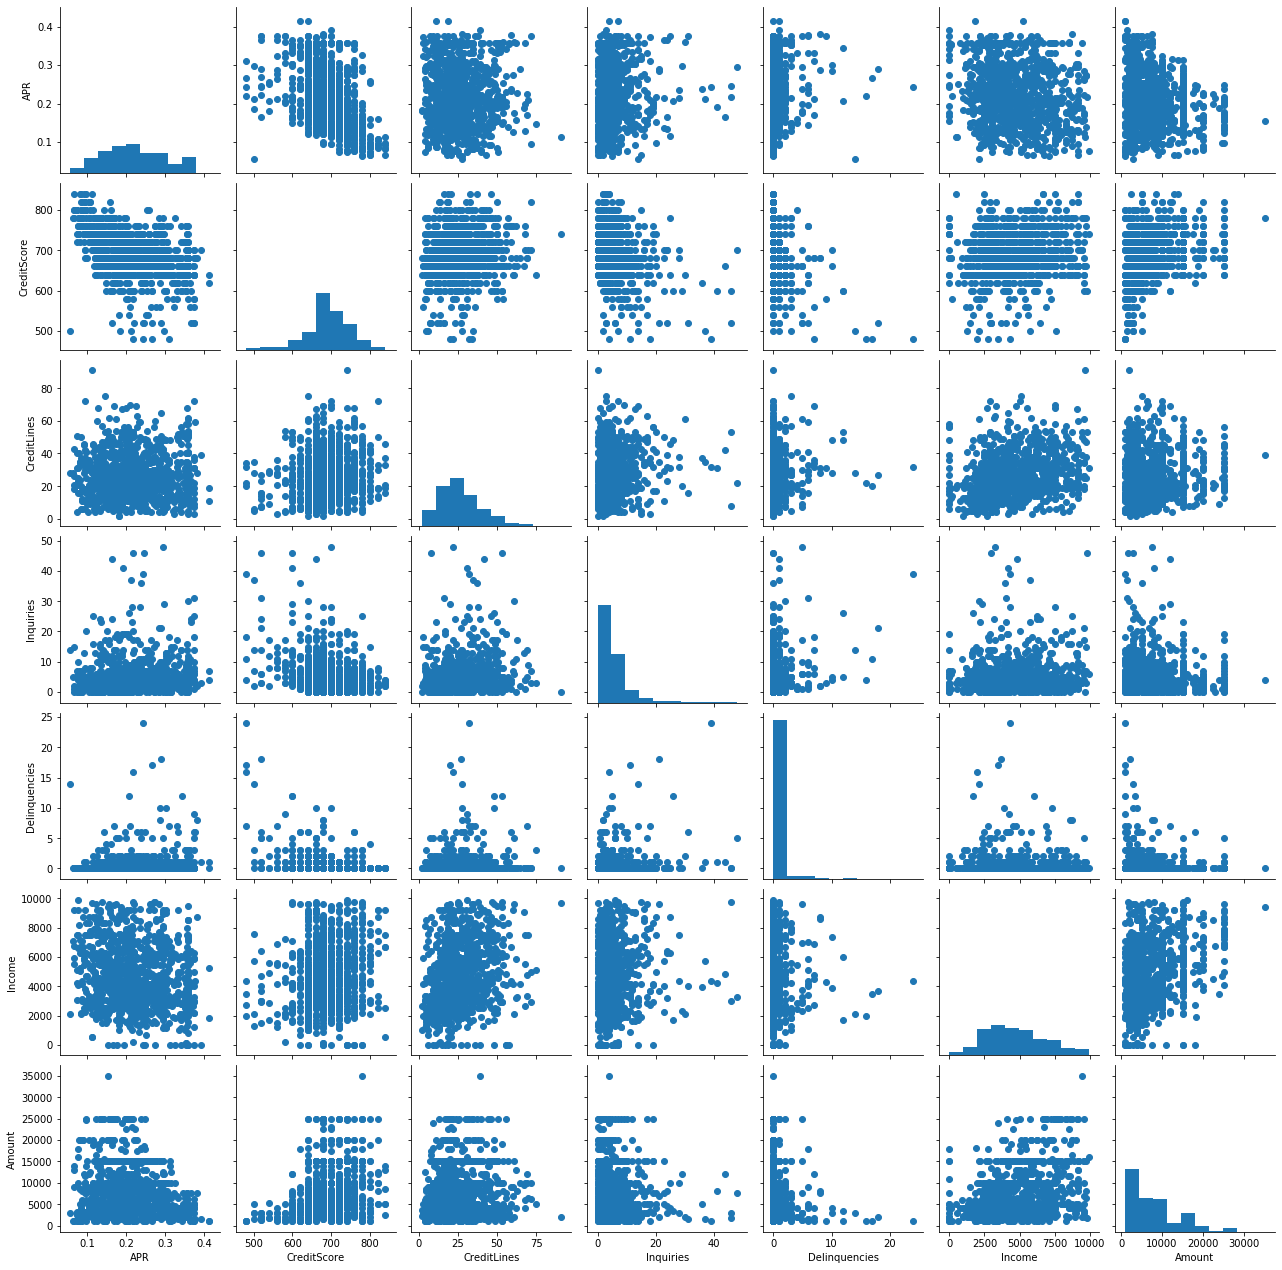

In [176]:
random_samp = loans_10k.sample(1000,random_state=42)
g = sb.PairGrid(data = random_samp, vars = numeric_vars) # taking a sample to render the charts faster
g = g.map_diag(plt.hist, bins = 10);
g.map_offdiag(plt.scatter);

_As it can be seen from the heat map and the correlation plots there's a moderate negative correlation between the credit score and the APR which is not a surprise since the higher credit score indicate a good finance discipline of a borrower who can be offered better credit options._

_The negative correlation between the credit score and the number of delinquencies also makes sense since delinquencies may lead to great decrease of credit score._

_The loan amount and the APR are also correlated negatively since the greater loan amount are often offered with low APR._

_The positive correlation between the credit score and the loan amount is explained by the fact that borrowers with better financial discipline are allowed to loan more money. Interestingly that the number of opened credit lines doesn't seem to impact the amount of loan much._

_Next, I'll create box plot to see the distibution of the income, the loan amount and the APR across Term, the fact of owning a home and the employment since those variables should have a great impact on the income, the loan amount and the APR._

In [177]:
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    base_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = base_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = random_samp, y_vars = ['Income', 'Amount','APR'], x_vars = nominal_vars,
                height = 3, aspect = 1.5)
plt.xticks(rotation = 90)
g.map(boxgrid)
plt.show();

<Figure size 720x720 with 0 Axes>

_As it can be seen from the box plots the 36-month term loans are given to the borrowers with the lowest median income and 12-month term loans are given to the borrowers whose median is slighly higher. Homeowners have slightly higher median income. It's worth noting that employed borrowers has the highest max income and one of the highest median income._

_The median amount of loan increases as term value increases. Homeowners has slighly larger loan amount than those who doesn't own a home. Employed and self-employed borrowers have the highest median loan amount._

_APR interquartile range decreases as the term length increases but the median stays almost the same. Also 36-month loan has the highest range between min and max APR values. The fact of owning a home also doesn't impact the APR much. For the employment status it can be seen that those who are not employed have the highest median and max APR and retired borrowers has the lowest median APR._

_I want to look at the percentage of each loan status across terms and each Prosper Score value across the Employment Status. For that purpose I will use clustered barchart showing the percentage of each element in a cluster._

In [178]:
%%capture
with_score = loans[loans.ProsperScore >0] # we're interested only in scores that available
ordinal = np.arange(1,12,1)
categ = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal)
with_score.ProsperScore = with_score.ProsperScore.astype(categ)

In [179]:
def perc_group(data,grp1,grp2):
    """groups data by the first (grp1) and the second (grp2) grouping values in a selected dataframe (data)"""
    grp = data.groupby([grp1,grp2])['Key'].count().reset_index()
    df = pd.DataFrame({grp1:grp[grp1],grp2:grp[grp2],'Key':grp.Key})
    df['prop'] = df.Key/[df[df[grp1] == i]['Key'].sum() for i in df[grp1]]
    df.drop('Key',axis = 1,inplace = True)
    df = df.pivot(index = grp1, columns = grp2, values = 'prop')
    df.columns = df.columns.tolist()
    df[grp1] = df.index.tolist()
    return df

In [180]:
def plot_perc(*args):
    """creates the unlimited number and sequential palete of clustered bar charts for ordered data"""
    pal = sb.light_palette("navy", as_cmap=True)
    fig, ax = plt.subplots(len(args), 1, figsize = (8,8))
    ranges = [np.arange(0,1.1,0.2),np.arange(0,0.31,0.1)]
    for n, arg in enumerate(args):
        bars = arg.plot(x=arg.iloc[:,-1].name, y=arg.iloc[:,:-1].columns.tolist(), kind='bar', cmap=pal,ax=ax[n])
        tick_names = ['{:.0%}'.format(v) for v in ranges[n]]
        bars.set_yticks(ranges[n])
        bars.set_yticklabels(tick_names)
        bars.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

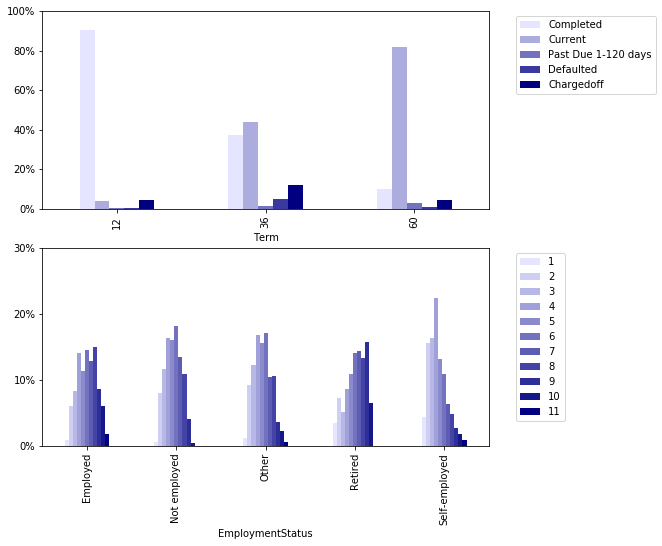

In [181]:
term_grp, emp_grp = perc_group(loans,'Term','Status'), perc_group(with_score,'EmploymentStatus','ProsperScore')
plot_perc(term_grp, emp_grp)

_As it can be seen from the charts the percentage of completed loans decreases as the term increases which makes sence since the long term loans will take more time to complete. It's also interesting that the proportion of charged off and defaulted loans is the highest in 36-month term._

_The distributions of Prosper scores shows that they are symmetrical for all employment categories except for self-employed and retired. It can also be seen that Employed and Retired have the higher percentage of high scores (10 and 11)._

_Now I'll look how my main variables of interest - the loan amount and the APR correlate with Credit Score by creating a scatterplot. I'll apply log transformation to the loan amount scale to make the relationship look more linear._

In [182]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans, x = 'Amount', y = 'CreditScore', alpha = 0.05)
plt.xlabel('Amount')
plt.ylabel('CreditScore')
plt.xscale('log')
plt.xticks([1e3, 2e3, 4e3, 8e3, 16e3, 35e3], ['1k','2k', '4k', '8k', '16k', '35k'])
plt.ylim(400,900);

In [183]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans, x = 'APR', y = 'CreditScore', alpha = 0.01)
plt.xlabel('APR')
plt.ylabel('CreditScore')
plt.ylim(400,900);

_These plots show that there's a positive correlation between credit score and loan amount and a negative correlation between credit score and APR. The correlation between credit score and loan amount is not so strong as between credit score and APR. Nevertheless we can see that credit score affects both the loan amount and the APR._

_I will create violin plot to see the distribution of the loan amount and the APR across category 4 most popular categories excluding "Not Available" and across statuses._

In [184]:
# compute the logarithm of price to make multivariate plotting easier
def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

loans['log_amount'] = loans.Amount.apply(log_trans)

In [138]:
# selecting the top 4 categories excluding 'Not Available'
%%capture
top4cat_dist = loans[loans.Category.isin(['Debt Consolidation', 'Other', 'Home Improvement', 'Business'])]
top4cat_dist.Category = top4cat_dist.Category.astype(str)

UsageError: Line magic function `%%capture` not found.


In [135]:
def viol_plt(data, x):
    """creates violin plots for the loan amount and the APR from specified dataframe (data) and categories(x)"""
    fig, ax = plt.subplots(ncols = 2, nrows = 1 , figsize = [6,6])
    fig.tight_layout(pad=2.0)
    x1 = sb.violinplot(data = data, x = x, y = 'log_amount', ax = ax[0], color = base_color,inner='quartile')
    y1 = sb.violinplot(data = data, x = x, y = 'APR', ax = ax[1], color = base_color,inner='quartile')
    for x,y in zip(x1.get_xticklabels(),y1.get_xticklabels()):
        x.set_rotation(90),y.set_rotation(90)
    ax[0].set_yticks(log_trans(np.array([1e3, 2e3, 4e3, 8e3, 16e3, 35e3])))
    ax[0].set_yticklabels(['1k','2k', '4k', '8k', '16k', '35k']);

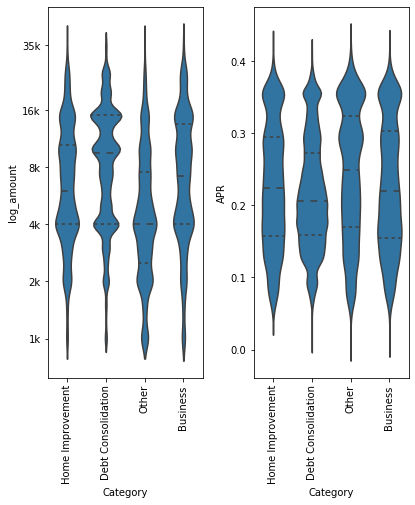

In [136]:
viol_plt(top4cat_dist, 'Category')

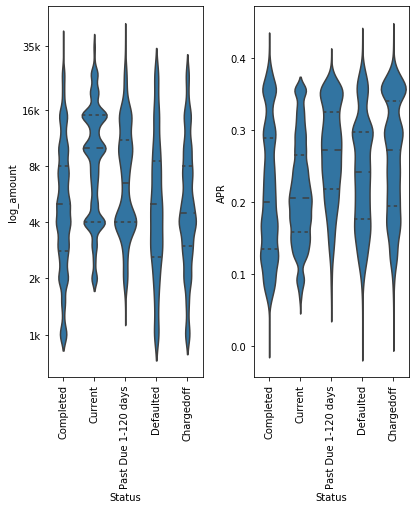

In [48]:
viol_plt(loans, 'Status')

_The violin plots show that the debt consolidation category holds the highest median loan amount and one of the lowest APR. Chargedoff and Defaulted median loan amount are relatively low and APR of Chargedoff and Defaulted are relatively high._ 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

_Credit score turned out to be the most impactful variable on loan amount and APR. Homeowners have slightly better conditions of loans. The median loan amount increases with terms but APR doesn't change much across terms. Employed and unemployed borrowers have the higher median loan amount and lower median APR.The highest proportion of chargedoffs and defaults are in 36-term loans. Retired borrowers has the highest proportion of high Prosper Score. The most common category of loans - debt consolidation also has the highest median loan and the lowest APR.
Chargedoff and Defaulted loans have the lowest median loan amount and delayed loans have the highest median APR._

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

_It was interesting to see that the median loan amount increases as the term increases, the APR stays almost the same and that the fact of owning a home doesn't impact loan amount and APR very much. It was also interesting to see that 36-month term has the highest proportion of defaulted and chargedoff loans. It's worth noting that debt consolidation category has the highest median loan amount and the lowest median APR and charged off and delayed loan have the lowest median loan amount and the 2nd and 3rd highest APR._

## Multivariate Exploration
<a id='multivariate'></a>

_I will create faceted grids to see the clusters of data points of the credit score vs. the APR across terms, statuses and terms combined with statuses._ 

In [57]:
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    bins_x = np.arange(loans.APR.min(), loans.APR.max()+.01, .02)
    bins_y = np.arange(400, 900, 20)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 1)

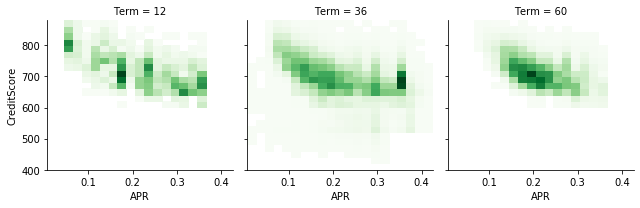

In [58]:
# create faceted heat maps on levels of the cut variable
g = sb.FacetGrid(data = loans, col = 'Term', size = 3)
g.map(hist2dgrid, 'APR', 'CreditScore', color = 'Greens')
g.set_xlabels('APR')
g.set_ylabels('CreditScore');

In [59]:
# create faceted heat maps on levels of the status variable
g = sb.FacetGrid(data = loans, col = 'Status', col_wrap = 3, size = 3)
g.map(hist2dgrid, 'APR', 'CreditScore', color = 'Greens')
g.set_xlabels('APR')
g.set_ylabels('CreditScore');

_It can be seen that 60-month term has the smallest range of APR while 36-month term has broader range of APR with darker spots near 0.4 which indicates that there a lot of offers with high APR. It can also be seen that current loans have mostly average APR while there are a lot of loans with hihg APR in delayed, defaulted or chargedoff loans._

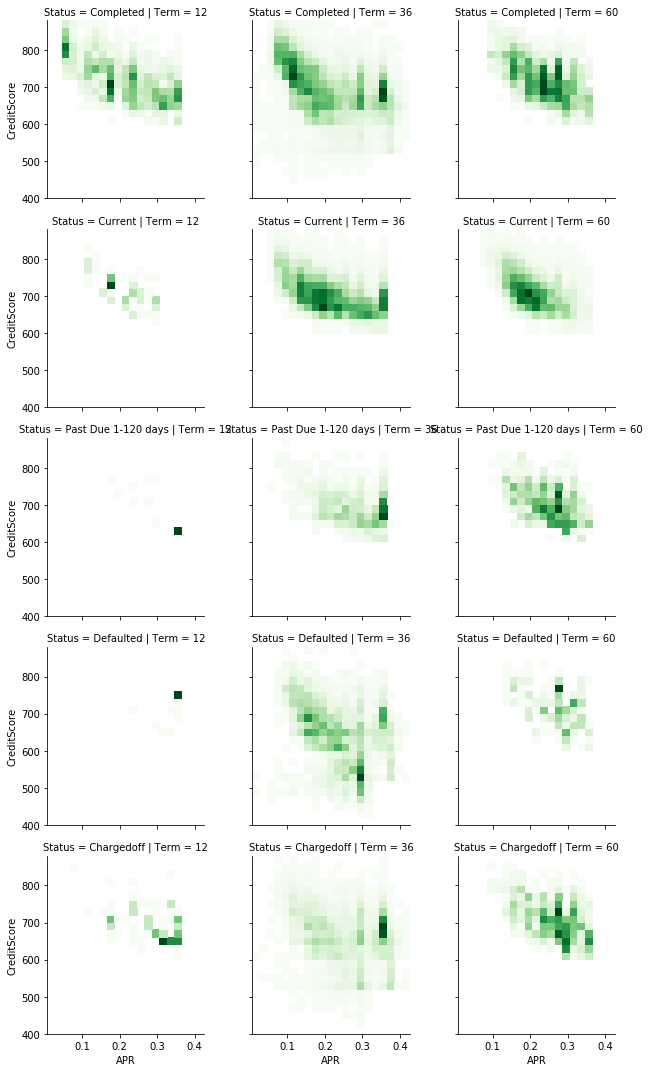

In [61]:
g = sb.FacetGrid(data = loans, col = 'Term', row = 'Status', size = 3)
g.map(hist2dgrid, 'APR', 'CreditScore', color = 'Greens')
g.set_xlabels('APR')
g.set_ylabels('CreditScore');

_Looking at faceted heat map across two quality dimensions it can be seen that there are a lot of loans with high APR that were delayed, defaulted or chargedoff in 36 and 60 month terms and some of those loans go with high credit score. It's also worth noting that some of the delayed 36-month term loans have similar APR as current loans do but there are many completed loans of 36-month term with high APR too._

_Finally, I'll create a point plot to see the distribution of the loan amount across the Prosper score values._

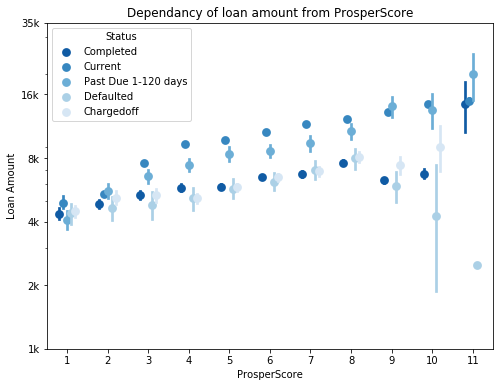

In [62]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = with_score, x = 'ProsperScore', y = 'Amount', hue = 'Status',
           palette = 'Blues_r', linestyles = '', dodge = 0.4)
plt.title('Dependancy of loan amount from ProsperScore')
plt.yscale('log')
plt.yticks([1e3, 2e3, 4e3, 8e3, 16e3, 35e3], ['1k','2k', '4k', '8k', '16k', '35k']);
plt.ylabel('Loan Amount');

_The plot shows that the highier ProsperScore the higher the loan amount becomes. It worth noting that chargedoff and especially defaulted loan amounts start decreasing after ProsperScore of 8. It's also interesting that the loan amount has broader ranges at ProsperScore of 9, 10 and 11 for defaulted loans._

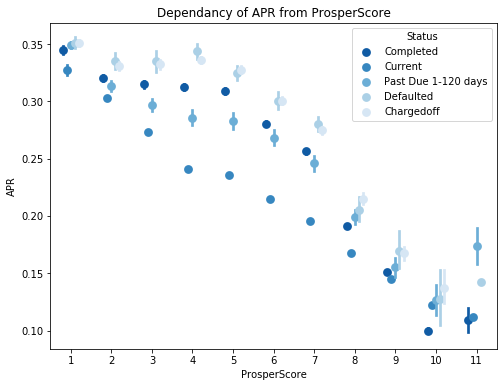

In [63]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = with_score, x = 'ProsperScore', y = 'APR', hue = 'Status',
           palette = 'Blues_r', linestyles = '', dodge = 0.4)
plt.title('Dependancy of APR from ProsperScore')
plt.ylabel('APR');

_The plot shows a strong negative correlation between ProsperScore and APR. We can see that at ProsperScore of 11 there were no chragedoffs abd for 10 there was larger range of APR for delayed, defaulted and chargedoff loans at ProsperScore of 10 but for completed and current loans the APR has a small range for all values of ProsperScore._

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

_I dove deep into the ProsperScore, Status and Term to see if there's any relationship between them and APR and Loan Amount. During the investigation I discovered that 60-month term has the most data at relatively low APR range whlie 36- and 12-month term has more data in larger APR zone and almost all loans with low APR have pretty high credit score. Many loans in "Completed" and "Current" have also high credit score and low APR while defaulted and chardged off loans have more data points that have higher APR and lower Credit Score. It was observed that ProsperScore impacts loan amount and APR - the higher the ProsperScore the higher the amount and the lower APR even though the exceptions were observed._

### Were there any interesting or surprising interactions between features?

_It was surprising that defauled and chargedoff loans have more data points in lower credit score zone than the completed and the current ones. It was also surprising that even though 60-month term loans have good credit score and low APR I observed some data points with high credit score and low APR among defaulted and chardgedoff loans. It was also interesting to see that even though the loan amount increases and the APR decreases as the Prosper Score increases it still can be seen that the loan amount of defaulted loans started decreasing from the value 8._

## Links
<a id='links'></a>

[What does it mean to default on a loan](https://www.valuepenguin.com/loans/what-does-it-mean-to-default-on-a-loan)

[How to Place Legend Outside of The Plot](https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/)

[How to convert CategoricalIndex to normal Index](https://stackoverflow.com/questions/60203258/how-to-convert-categoricalindex-to-normal-index)